# Probe regularizations figure

> Georgios Varnavides*, Stephanie Ribet* et al.  
> 05/20/2024

This notebook reproduces the probe regularizations figure (Fig. 14) in the manuscript [Iterative Phase Retrieval Algorithms for Scanning Transmission Electron Microscopy](https://arxiv.org/abs/2309.05250).

## Imports

In [1]:
import numpy as np
import py4DSTEM
import h5py
print(py4DSTEM.__version__)

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colors as mcolors
from colorspacious import cspace_convert
import cmasher as cmr

0.14.14


## Data

In [3]:
# complex probe
with h5py.File("data/probe_fourier.h5","r") as f:
    probe_init = f['probe'][:]

probe_init_corner_centered = np.fft.ifftshift(probe_init)
probe_init_abs = np.abs(probe_init_corner_centered)
probe_init_angle = -np.angle(probe_init_corner_centered)

## Aperture Constraints

In [ ]:
probe_corr, polar_int, polar_int_corr, coeffs = py4DSTEM.process.phase.utils.regularize_probe_amplitude(
    probe_init_corner_centered,
    width_max_pixels = 3.0,
    nearest_angular_neighbor_averaging=5,
    corner_centered=True,
    enforce_constant_intensity = False,
)

probe_corr_const, polar_int_const, polar_int_corr_const, coeffs_const = py4DSTEM.process.phase.utils.regularize_probe_amplitude(
    probe_init_corner_centered,
    width_max_pixels = 3.0,
    nearest_angular_neighbor_averaging=5,
    corner_centered=True,
    enforce_constant_intensity = True,
)

## Aberrations Constraints

In [5]:
fitted_angle, fit_coeff = py4DSTEM.process.phase.utils.fit_aberration_surface(
    complex_probe=probe_corr_const,
    energy=200e3,
    use_scikit_image=True,
    probe_sampling=(0.27,0.27),
    max_angular_order = 5,
    max_radial_order = 6,
)

fitted_probe = np.abs(probe_corr_const) * np.exp(-1j*fitted_angle)
fitted_angle_wrapped = np.mod(fitted_angle - np.pi,2*np.pi) - np.pi

## Aberrations Basis

In [6]:
basis, index = py4DSTEM.process.phase.utils.aberrations_basis_function(
    energy=200e3,
    probe_size= probe_init.shape,
    probe_sampling = (0.27,0.27),
    max_angular_order = 5,
    max_radial_order = 6,
)

basis_wrapped = np.mod(basis - np.pi,2*np.pi) + np.pi

## Visualizations

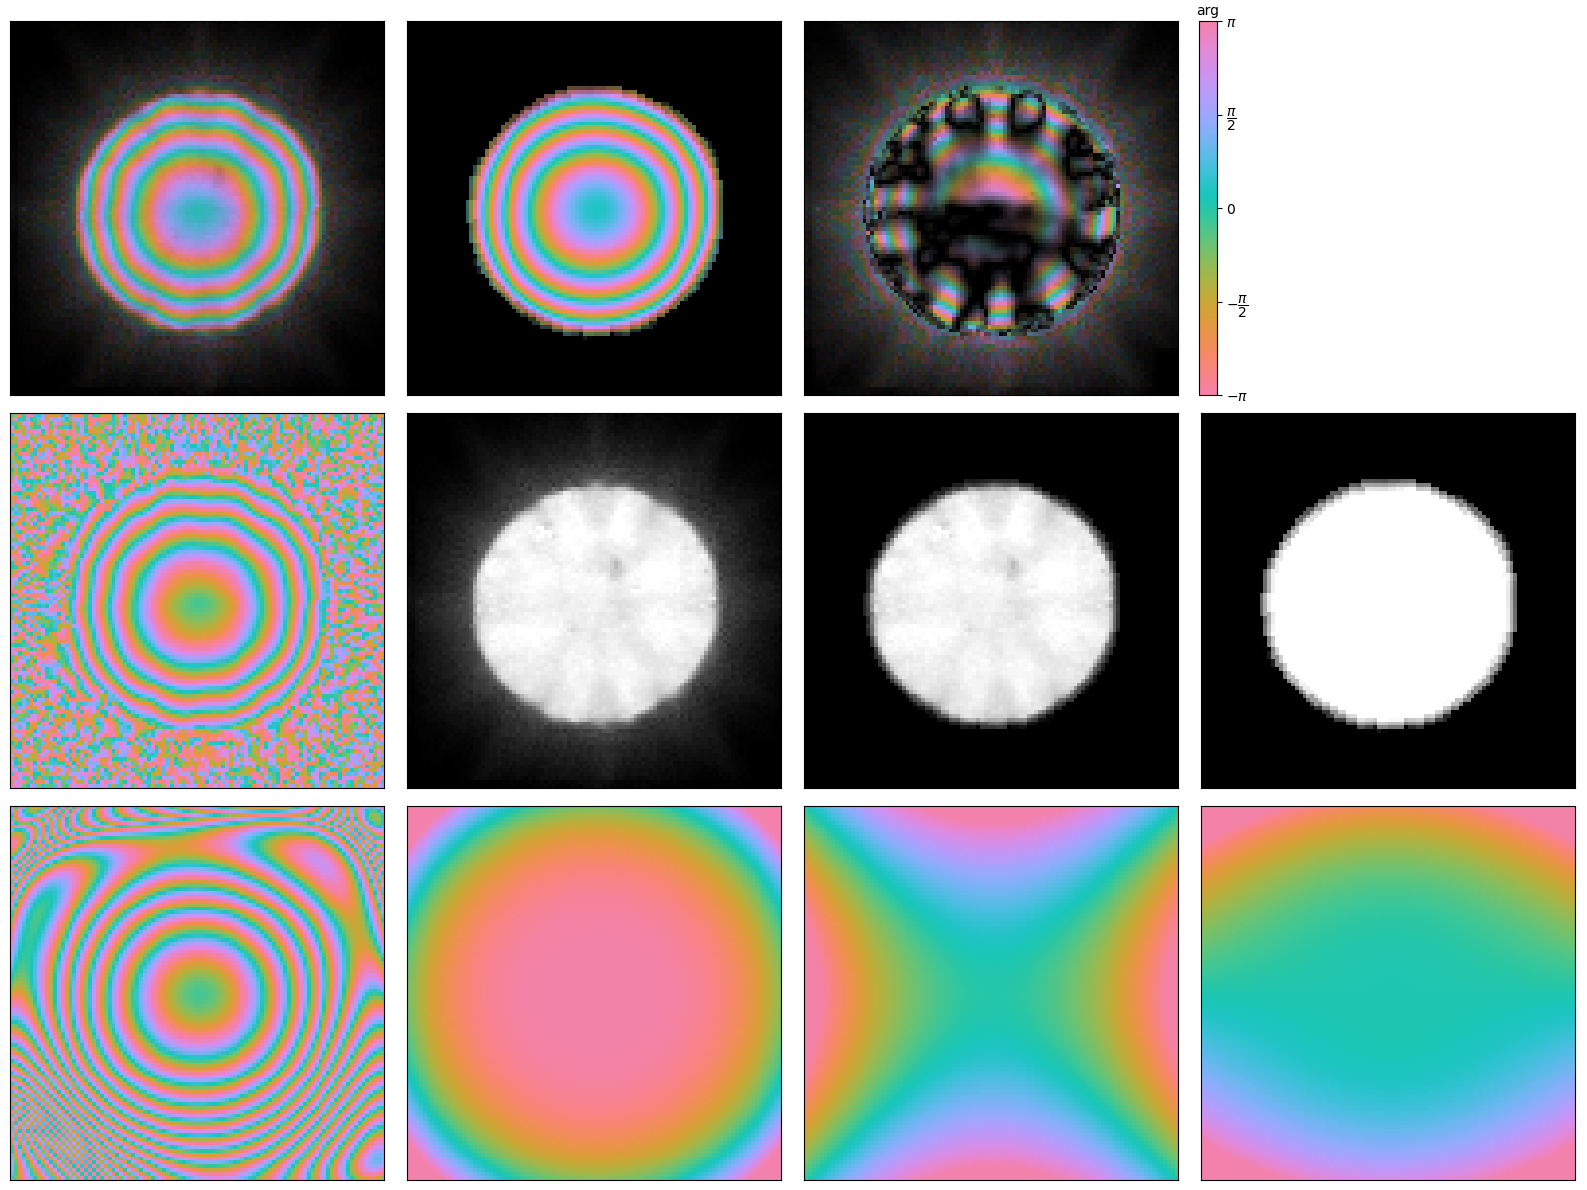

In [9]:
# spec
fig = plt.figure(figsize=(4*4,3*4))
gs = fig.add_gridspec(
    ncols=4,
    nrows=3,
)
axes = gs.subplots()

# aberration surface cmap
h = np.linspace(0, 360, 256, endpoint=False)
J = np.full_like(h, 61.5)
C = np.full_like(h, 49)
JCh = np.stack((J, C, h), axis=-1)
rgb_vals = cspace_convert(JCh, "JCh", "sRGB1").clip(0, 1)
cmap = mcolors.ListedColormap(rgb_vals)

# complex probes
py4DSTEM.show_complex(
    [
        np.fft.fftshift(probe_init_corner_centered),
        np.fft.fftshift(fitted_probe),
        np.fft.fftshift(probe_init_corner_centered-fitted_probe)
    ],
    ticks=False,
    cbar=False,
    figax=(fig,axes[0,:3])
)

# aberration surface
py4DSTEM.show(
    [   
    np.fft.fftshift(probe_init_angle),
    np.fft.fftshift(fitted_angle_wrapped),
    ],
    ticks=False,
    cmap=cmap,
    figax=(fig,axes[1:,0])
)

# apertures
py4DSTEM.show(
    [
        np.fft.fftshift(probe_init_abs),
        np.fft.fftshift(np.abs(probe_corr)),
        np.fft.fftshift(np.abs(probe_corr_const)),
    ],
    ticks=False,
    cmap=cmr.neutral,
    figax=(fig,axes[1,1:])
)

#basis
py4DSTEM.show(
    [
        np.fft.fftshift(basis_wrapped[:,2].reshape((96,96))),
        np.fft.fftshift(basis_wrapped[:,4].reshape((96,96))),
        np.fft.fftshift(basis_wrapped[:,6].reshape((96,96)))
    ],
    cmap=cmap,
    ticks=False,
    figax=(fig,axes[2,1:])
)

# colobar
divider = make_axes_locatable(axes[0,3])
ax_cbar_small = divider.append_axes("left",size="5%",pad=0)
axes[0,3].axis("off")

py4DSTEM.visualize.add_colorbar_arg(ax_cbar_small)

gs.tight_layout(fig)

## Postprocessing
> Done in Inkscape